### 匯入函式庫

In [21]:
# 事前準備
import os
import numpy as np          # 資料處理分析工具
import pandas as pd         # 資料處理分析工具
from scipy import stats     # 統計函式庫
from scipy.stats import norm, skew
from collections import Counter # counter是字典，用來計數，key是要計數的item，value儲存的是個數
from sklearn.preprocessing import LabelEncoder # 用於特徵提取, 將數值資料轉為離散
from sklearn.preprocessing import MinMaxScaler

# 匯入必要的函式庫
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

import datetime as dt
import string
from google.cloud import bigquery

# 資料視覺化
import matplotlib.pyplot as plt
from matplotlib import rcParams, pyplot as plt, style as style
%matplotlib inline
import seaborn as sns
color = sns.color_palette() # 生成各種顏色
sns.set_style('darkgrid') # 設置主題：darkgrid、whitegrid、dark、white、ticks
# 設定展示欄位最大值
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

### 確認資料

In [22]:
calendar = pd.read_csv('.\data\Seattle Airbnb Open Data\calendar.csv')

calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,68396,2020-06-01,f,"$1,498.00","$1,498.00",7.0,365.0
1,271733,2020-06-02,f,$800.00,$800.00,5.0,182.0
2,271733,2020-06-03,f,$800.00,$800.00,5.0,182.0
3,271733,2020-06-04,f,$800.00,$800.00,5.0,182.0
4,271733,2020-06-05,f,$800.00,$800.00,5.0,182.0


In [23]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3069763 entries, 0 to 3069762
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 163.9+ MB


#### 檢查最早到最後的時間
- 確認資料為一年的時間

In [24]:
calendar.date.min(), calendar.date.max()

('2020-05-31', '2021-06-02')

#### 檢查缺失值

In [25]:
calendar.isnull().sum()

listing_id          0
date                0
available           0
price               0
adjusted_price      0
minimum_nights    453
maximum_nights    453
dtype: int64

#### 因為數據量夠大, 因此直接drop掉

In [26]:
calendar = calendar.dropna()

#### 將 date 這種時間格式進行轉換

In [27]:
calendar['date'] = pd.to_datetime(calendar['date'])

calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3069310 entries, 0 to 3069762
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           object        
 4   adjusted_price  object        
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 187.3+ MB


#### 處理 price 價格特徵 object
- 解決他有字串又有數字的 object 類型
- astype做型態轉換

In [28]:
calendar['price'] = calendar['price'].str.replace('$','') # 移除錢字號
calendar['price'] = calendar['price'].str.replace(',','') # 移除逗號

# astype做型態轉換
calendar['price'] = calendar['price'].astype(float)
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3069310 entries, 0 to 3069762
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           float64       
 4   adjusted_price  object        
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 187.3+ MB


#### 提取時間中我需要的指標
- 利用 groupby 取得群體
- 利用 .dt.strftime('%B') 得到月份群體
- 發現 四五六月是旺季

<AxesSubplot:ylabel='date'>

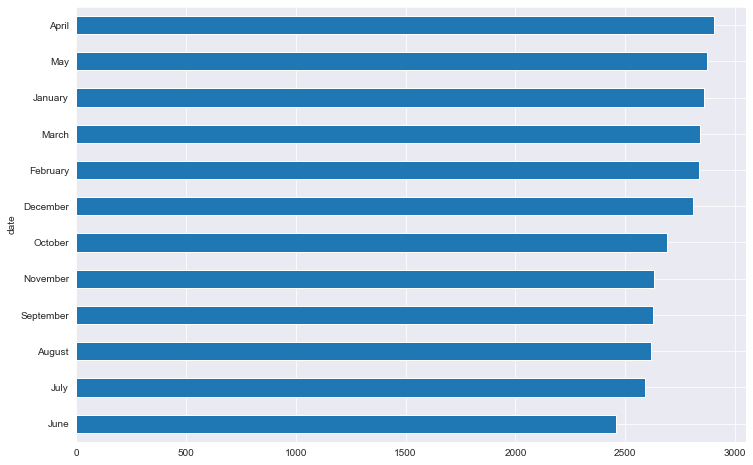

In [29]:
mean_of_mouth = calendar.groupby(calendar['date'].dt.strftime('%B'))['price'].mean()

# 圖示化各月份的價格平均
mean_of_mouth.sort_values(ascending=True,inplace=True)
mean_of_mouth.plot(kind='barh',figsize=(12,8))

#### 新增一個特徵為 (星期 dayofweek)
- 使用 .dt.day_name() 可以從 date資料取得星期資料
- 發現 星期五六 價格最高

<AxesSubplot:xlabel='dayofweek'>

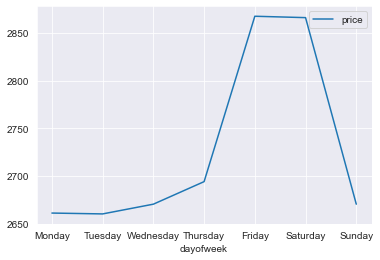

In [30]:
# 新增一個特徵
calendar['dayofweek'] = calendar.date.dt.day_name()

# 建立星期 index
cats = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# 取得每天平均的各特徵資料
calendar.groupby(['dayofweek']).mean()

# 將日期index重新排列, 建立一個群組
price_week = calendar.groupby(['dayofweek']).mean().reindex(cats)

# 沒有必要的特徵 就拿掉
price_week.drop('listing_id',axis=1, inplace = True)
price_week.drop('minimum_nights',axis=1, inplace = True)
price_week.drop('maximum_nights',axis=1, inplace = True)

# 劃出當前結果
price_week.plot()

### 房間資訊
- listing 只包含房間的資訊

In [31]:
listings = pd.read_csv('.\data\Seattle Airbnb Open Data\listings.csv',encoding='latin1')
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,68396,https://www.airbnb.com/rooms/68396,2.020050e+13,2020/6/1,Zhongxiao Dunhua Studio C near MRT,Prime location! Right in the center of Taipei'...,Located at Zhongxiao East Road of Daan distric...,Prime location! Right in the center of Taipei'...,none,NaN,[Additional Service] - Flat Iron and Iron Boar...,NaN,NaN,NaN,[ Tenant Policy ] The minimum stay is 1 mont...,NaN,NaN,https://a0.muscache.com/im/pictures/b82f75f2-8...,NaN,339014,https://www.airbnb.com/users/show/339014,Lisa,2011/1/7,"Taipei, Taiwan",Hello world!! My name is Lisa and I'm super ex...,within an hour,100%,95%,t,https://a0.muscache.com/im/users/339014/profil...,https://a0.muscache.com/im/users/339014/profil...,Da'an,12,12,"['email', 'phone', 'facebook', 'reviews', 'off...",t,f,"Daan District, Taiwan",Da'an,¤j¦w°Ï,NaN,Daan District,NaN,106,Taipei,"Daan District, Taiwan",TW,Taiwan,25.04258,121.55365,t,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,"$1,498.00",NaN,"$35,951.00","$8,988.00",NaN,2,$0.00,7,365,7,7,365,365,7.0,365.0,6 weeks ago,t,29,59,89,364,2020/6/1,2,0,2013/5/23,2018/6/20,100.0,9.0,10.0,10.0,10.0,10.0,10.0,f,NaN,"{""Taiwan VAT Tax""}",f,f,strict_14_with_grace_period,f,f,12,12,0,0,0.02
1,68398,https://www.airbnb.com/rooms/68398,2.020050e+13,2020/6/2,Tonghua Vacation Studio C near MRT & Taipei 101,Convenient location; close to MRT and walking ...,Private Studio apartment with ensuite bathroom...,Convenient location; close to MRT and walking ...,none,Locates in a quiet neighborhood of Tonghua Str...,Please note that there is no elevator in the b...,7 mind walk to MRT Xinyi Anhe Station 10 minut...,32¡¨ TV Sofa couch & Coffee table Queen size d...,NaN,[ Tenant Policy ] The minimum stay is 1 mont...,NaN,NaN,https://a0.muscache.com/im/pictures/28357420/c...,NaN,339014,https://www.airbnb.com/users/show/339014,Lisa,2011/1/7,"Taipei, Taiwan",Hello world!! My name is Lisa and I'm super ex...,within an hour,100%,95%,t,https://a0.muscache.com/im/users/339014/profil...,https://a0.muscache.com/im/users/339014/profil...,Da'an,12,12,"['email', 'phone', 'facebook', 'reviews', 'off...",t,f,"Daan District, Taiwan",Da'an,¤j¦w°Ï,NaN,Daan District,NaN,106,Taipei,"Daan District, Taiwan",TW,Taiwan,25.02925,12

#### 觀察一下評分
- 看得出來大部分的人都給好評 台北的房子不錯

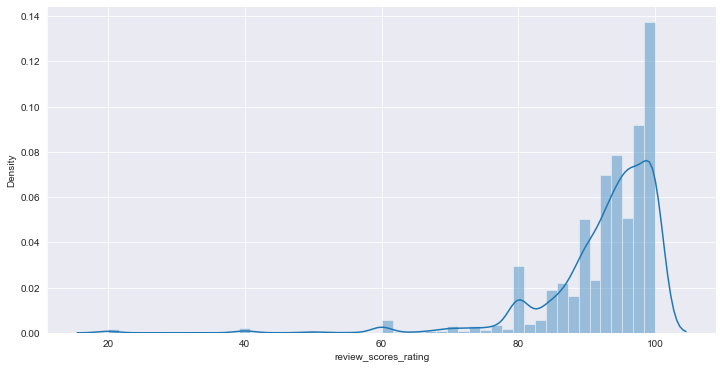

count    6515.000000
mean       92.563315
std         8.701235
min        20.000000
25%        90.000000
50%        95.000000
75%        98.000000
max       100.000000
Name: review_scores_rating, dtype: float64

In [32]:
plt.figure(figsize=(12,6))
sns.distplot(listings.review_scores_rating.dropna())
sns.despine()
plt.show()

# 看一下評分的描述
listings.review_scores_rating.describe()

#### 觀察一下房價
- 平均兩千五台幣

In [33]:
listings['price'] = listings['price'].str.replace('$','')
listings['price'] = listings['price'].str.replace(',','')
listings['price'] = listings['price'].astype(float)
listings['price'].describe()

count      8409.000000
mean       2542.481389
std        9712.377448
min           0.000000
25%         988.000000
50%        1496.000000
75%        2484.000000
max      300255.000000
Name: price, dtype: float64

#### 根據房價進行排序
- 可以看到最貴的房間樣式

In [34]:
high_price = listings.sort_values('price',ascending=False)
high_price.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
902,8525791,https://www.airbnb.com/rooms/8525791,2.020050e+13,2020/6/2,NaN,¥æ³q«K©y,NaN,¥æ³q«K©y,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/108353979/...,NaN,21117128,https://www.airbnb.com/users/show/21117128,½¼«},2014/9/9,"Da¡¦an District, Taipei City, Taiwan",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/f9d68...,https://a0.muscache.com/im/pictures/user/f9d68...,NaN,1,1,"['email', 'phone', 'reviews', 'work_email']",t,f,"¤j¦w°Ï, ¥x¥_, Taiwan",Da'an,¤j¦w°Ï,NaN,¤j¦w°Ï,¥x¥_,106,Taipei,"¤j¦w°Ï, Taiwan",TW,Taiwan,25.02310,121.54439,t,Other,Private room,1,0.0,1.0,1.0,Real Bed,"{Kitchen,""translation missing: en.hosting_amen...",NaN,300255.0,NaN,NaN,NaN,NaN,1,$0.00,1,1,1,1,1,1,1.0,1.0,42 months ago,t,29,59,89,89,2020/6/2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,"{""Taiwan VAT Tax""}",f,f,flexible,f,f,1,0,1,0,NaN
3282,21711457,https://www.airbnb.com/rooms/21711457,2.020050e+13,2020/5/31,Habitat of Wanderers,Hi,NaN,Hi,none,NaN,NaN,NaN,NaN,NaN,No shoes in the room.,NaN,NaN,https://a0.muscache.com/im/pictures/723bcf22-5...,NaN,46160802,https://www.airbnb.com/users/show/46160802,¬Rµ{,2015/10/9,Chiayi,NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/74b0d...,https://a0.muscache.com/im/pictures/user/74b0d...,NaN,1,1,"['email', 'phone']",t,f,"Datong District, Taipei City, Taiwan",Datong,¤j¦P°Ï,NaN,Datong District,Taipei City,103,Taipei,"Datong District, Taiwan",TW,Taiwan,25.07112,121.51008,t,Apartment,Shared room,1,1.0,1.0,1.0,Pull-out Sofa,"{Kitchen,Washer,Essentials,Shampoo,Hangers,""Ha...",NaN,300012.0,NaN,NaN,NaN,NaN,1,$0.00,1,7,1,1,7,7,1.0,7.0,31 months ago,t,0,0,0,0,2020/5/31,1,0,2017/11/20,2017/11/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,"{""Taiwan VAT Tax""}",t,f,flexible,f,f,1,0,0,1,0.03
305,3783777,https://www.airbnb.com/rooms/3783777,2.020050e+13,2020/6/2,Room in Beitou,It's my house. Old style taiwanese room in old...,NaN,It's my house. Old style taiwanese room in old...,none,NaN,³Ì¤Ö»Ý¤U­q¤T±ß?at least three nights,NaN,"¤£¥]§t§N®ð¹q¶O,¦³¶}§N®ðªº¸Ü»Ý­n¨Ì·Ó¹qªí¥t¥~¦¬¶...",NaN,"©U§£­n¦Û¦æ±a¨«,¤HÂ÷¶}©Ð«Î®É¤ô¹q§N®ð­nÃö,§_«h·|...",NaN,NaN,https://a0.muscache.com/im/pictures/2f4fb8e6-1...,NaN,4927520,https://www.airbnb.com/users/show/4927520,Brendon,2013/2/1,"Taipei, Taiwan.",I

<AxesSubplot:>

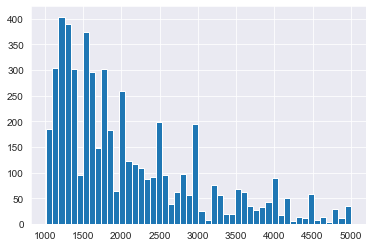

In [35]:
# 取得房價 1000 ~ 5000 的資料 
# 繪製成直方圖
listings.loc[(listings['price'] <= 5000) & (listings['price'] > 1000)].price.hist(bins=50)

#### 利用 boxplot 針對各種"房型"確認離群值
- 可以看出 Entire home 和 Hotel room 最貴
- boxplot() data為要判斷的數據
- 圖上方的黑點為離群點

<AxesSubplot:xlabel='room_type', ylabel='price'>

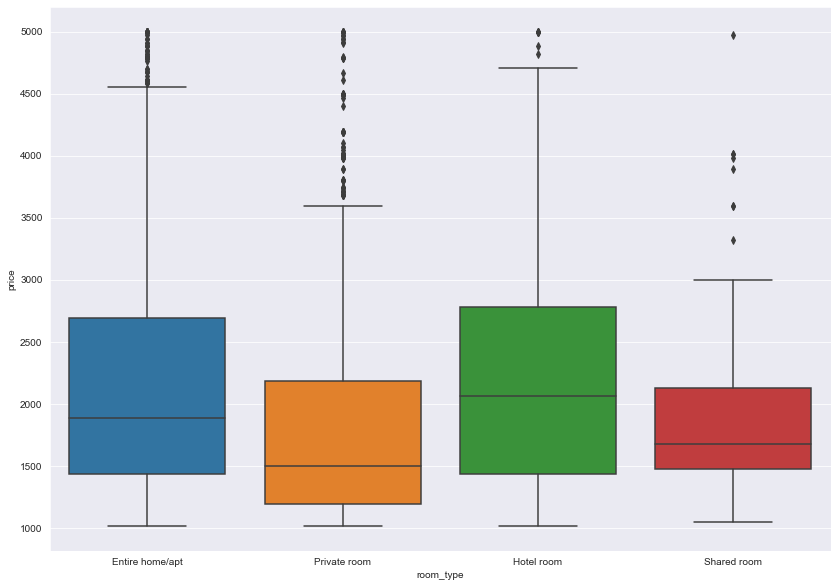

In [36]:
f,ax = plt.subplots(figsize=(14,10))
sns.boxplot(y='price',x='room_type',data=listings.loc[(listings['price']<=5000) & (listings['price']>1000)])

#### 確認房內設施
- 電視, 網路WIFI等等....
- 將各種設施獨立取出並做統計

In [37]:
listings.amenities[:5]

# 移除設施特徵那些奇怪的東西
listings.amenities = listings.amenities.str.replace('[{}]','').str.replace('"','')

listings.amenities[:5]

0    TV,Cable TV,Internet,Wifi,Air conditioning,Whe...
1    TV,Cable TV,Internet,Wifi,Air conditioning,Kit...
2    TV,Cable TV,Internet,Wifi,Air conditioning,Pai...
3    TV,Cable TV,Internet,Wifi,Air conditioning,Pai...
4    Cable TV,Internet,Wifi,Air conditioning,Wheelc...
Name: amenities, dtype: object

In [38]:
# 針對設施做變換操作 對 amns 執行每個字串根據逗號做list變換
listings['amenities'].map(lambda amns:amns.split(','))[:5]

0    [TV, Cable TV, Internet, Wifi, Air conditionin...
1    [TV, Cable TV, Internet, Wifi, Air conditionin...
2    [TV, Cable TV, Internet, Wifi, Air conditionin...
3    [TV, Cable TV, Internet, Wifi, Air conditionin...
4    [Cable TV, Internet, Wifi, Air conditioning, W...
Name: amenities, dtype: object

In [39]:
# np.concatenate 可以做 list 拼接
np.concatenate(listings['amenities'].map(lambda amns:amns.split(',')))

array(['TV', 'Cable TV', 'Internet', ..., 'Hair dryer', 'Iron',
       'Laptop-friendly workspace'], dtype='<U42')

Air conditioning             8137
Wifi                         8069
Hair dryer                   7808
Essentials                   7702
Shampoo                      7698
TV                           7104
Hangers                      6999
Washer                       6656
Laptop-friendly workspace    6518
Fire extinguisher            6364
dtype: int64


<AxesSubplot:>

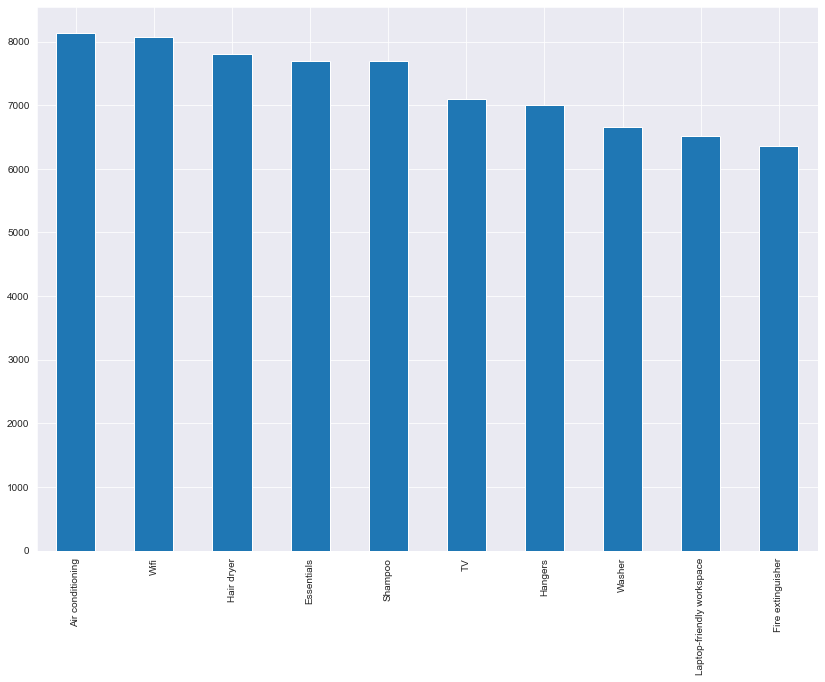

In [40]:
# 前十個最常見的設施 : 冷氣, wifi, 吹風機....
print(pd.Series(np.concatenate(listings['amenities'].map(lambda amns:amns.split(',')))).value_counts().head(10))

f,ax = plt.subplots(figsize=(14,10))
pd.Series(np.concatenate(listings['amenities'].map(lambda amns:amns.split(',')))).value_counts().head(10).plot(kind='bar')

### 特徵前處理
- 確認一下在房價1000~5000中 廁所與房間的關係
- 統計 'bathrooms 數量' 和 'bedrooms 數量' 的關係
- .pivot('上方row', '左方 column', 'value 統計的是price的指標')
- 發現一個(房間bedrooms)一個(廁所bathrooms)的房間最多!
- 發現六個房間六個廁所最貴!

In [41]:
# 數值特徵列
col = ['host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month']

In [42]:
# 根據房間數與廁所數計數 count()

cur_input = listings.loc[(listings['price']<=5000) & (listings['price']>0)].groupby(['bathrooms','bedrooms']).count()['price'].reset_index().pivot('bathrooms','bedrooms','price')

cur_input

bedrooms,0.0,1.0,2.0,3.0,4.0,5.0,6.0,8.0,11.0,12.0
bathrooms,,,,,,,,,,
0.0,8.0,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.5,4.0,45.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,588.0,4396.0,466.0,99.0,8.0,1.0,NaN,NaN,NaN,NaN
1.5,39.0,639.0,79.0,43.0,1.0,1.0,NaN,NaN,NaN,NaN
2.0,5.0,248.0,184.0,187.0,33.0,1.0,1.0,NaN,NaN,NaN
2.5,NaN,47.0,11.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN
3.0,1.0,241.0,10.0,44.0,14.0,4.0,NaN,1.0,NaN,NaN
3.5,NaN,13.0,NaN,5.0,1.0,1.0,NaN,NaN,NaN,NaN
4.0,NaN,45.0,NaN,2.0,3.0,1.0,1.0,NaN,NaN,NaN


<AxesSubplot:xlabel='bedrooms', ylabel='bathrooms'>

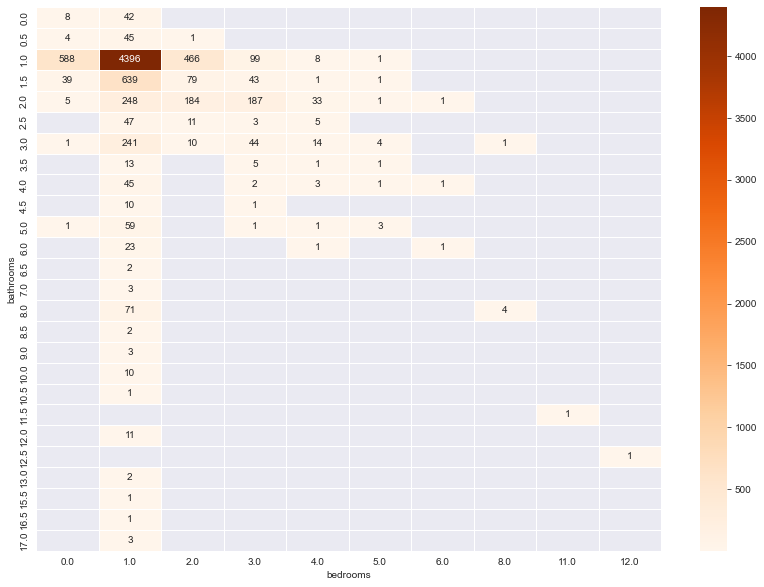

In [43]:
# 房間數量可視化
#  fmt='.0f' 將科學記號轉數值
f,ax = plt.subplots(figsize=(14,10))
sns.heatmap(cur_input,cmap='Oranges',annot=True,linewidths=0.5, fmt='.0f')

In [44]:
# 取平均值而非計數 mean()

mean_input = listings.loc[(listings['price']<=5000) & (listings['price']>0)].groupby(['bathrooms','bedrooms']).mean()['price'].reset_index().pivot('bathrooms','bedrooms','price')

mean_input

bedrooms,0.0,1.0,2.0,3.0,4.0,5.0,6.0,8.0,11.0,12.0
bathrooms,,,,,,,,,,
0.0,1257.625000,1084.857143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.5,1759.750000,910.022222,1738.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,1614.200680,1508.630118,2391.313305,2931.303030,2443.500000,1408.0,NaN,NaN,NaN,NaN
1.5,1578.897436,1420.769953,2516.367089,2907.093023,4010.000000,1498.0,NaN,NaN,NaN,NaN
2.0,2989.800000,989.306452,3069.907609,3547.032086,3712.757576,3890.0,1198.0,NaN,NaN,NaN
2.5,NaN,1163.425532,3125.818182,1847.333333,3000.200000,NaN,NaN,NaN,NaN,NaN
3.0,1047.000000,1054.987552,3230.100000,3299.772727,3080.500000,3743.0,NaN,389.0,NaN,NaN
3.5,NaN,513.538462,NaN,3441.600000,3865.000000,1287.0,NaN,NaN,NaN,NaN
4.0,NaN,866.488889,NaN,2187.000000,4292.333333,1258.0,2187.0,NaN,NaN,NaN


<AxesSubplot:xlabel='bedrooms', ylabel='bathrooms'>

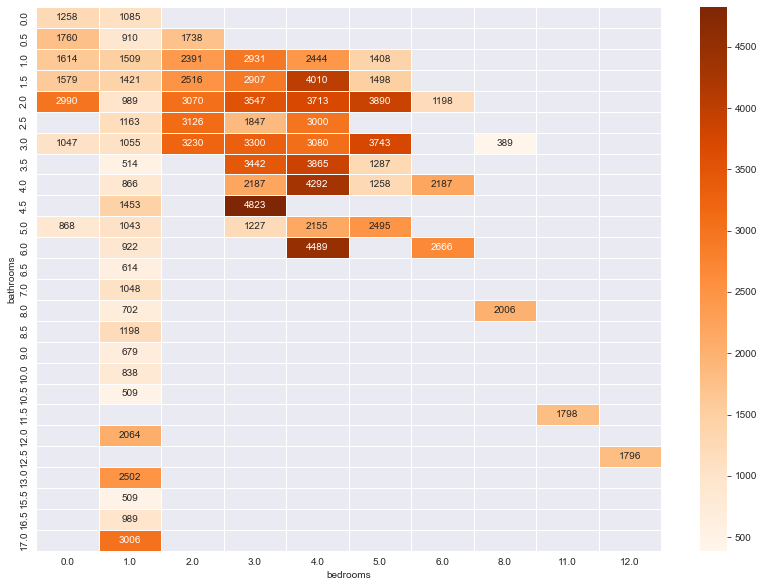

In [45]:
# 房間數量可視化
#  fmt='.0f' 將科學記號轉數值
f,ax = plt.subplots(figsize=(14,10))
sns.heatmap(mean_input,cmap='Oranges',annot=True,linewidths=0.5, fmt='.0f')

### 建立模型
- 重新讀取房間資訊資料, 並作前處理
- 將部分特徵資訊, 含有t & f 的 做些0、1轉換 (true/false => 0/1)

In [47]:
listings = pd.read_csv('.\data\Seattle Airbnb Open Data\listings.csv',encoding='latin1')
listings['price'] = listings['price'].str.replace('$','')
listings['price'] = listings['price'].str.replace(',','')
listings['price'] = listings['price'].astype(float)
listings = listings.loc[(listings['price'] <= 10000) & (listings['price'] > 0)] # 過濾離群值
listings.amenities = listings.amenities.str.replace('[{}]','').str.replace('"','')

In [48]:
columns =  ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
                   'is_location_exact', 'requires_license', 'instant_bookable',
                   'require_guest_profile_picture', 'require_guest_phone_verification']
for c in columns:
    listings[c] = listings[c].replace('f',0,regex=True)
    listings[c] = listings[c].replace('t',1,regex=True)

In [49]:
# 針對部分特徵 做 nan 補 0
# 移除特殊字元並轉成float格式

listings['security_deposit'] = listings['security_deposit'].fillna(value=0)
listings['security_deposit'] = listings['security_deposit'].replace( '[\$,)]','', regex=True ).astype(float)
listings['cleaning_fee'] = listings['cleaning_fee'].fillna(value=0)
listings['cleaning_fee'] = listings['cleaning_fee'].replace( '[\$,)]','', regex=True ).astype(float)

In [50]:
listings_new = listings[['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic','is_location_exact', 
                         'requires_license', 'instant_bookable', 'require_guest_profile_picture', 
                         'require_guest_phone_verification', 'security_deposit', 'cleaning_fee', 
                         'host_listings_count', 'host_total_listings_count', 'minimum_nights',
                     'bathrooms', 'bedrooms', 'guests_included', 'number_of_reviews','review_scores_rating', 'price']]

for col in listings_new.columns[listings_new.isnull().any()]:
    print(col)
    
for col in listings_new.columns[listings_new.isnull().any()]:
    listings_new[col] = listings_new[col].fillna(listings_new[col].median())
    
# 做 one-hot encoding    
for cat_feature in ['zipcode', 'property_type', 'room_type', 'cancellation_policy', 'neighbourhood_cleansed', 'bed_type']:
    listings_new = pd.concat([listings_new, pd.get_dummies(listings[cat_feature])], axis=1)

bathrooms
bedrooms
review_scores_rating


In [51]:
#listings_new = pd.concat([listings_new, df_amenities], axis=1, join='inner')

In [52]:
listings_new.head()

,host_is_superhost,host_identity_verified,host_has_profile_pic,is_location_exact,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,security_deposit,cleaning_fee,host_listings_count,host_total_listings_count,minimum_nights,bathrooms,bedrooms,guests_included,number_of_reviews,review_scores_rating,price,\n,*100,.,100,10041,10043,10045,10047,10049,10050,10061,10088,101,103,10353,10354,10356,10367,103¡]¶l»¼°Ï¸¹¡^,104,10445,10446,10451,10456,10457,10465,10469,10475,10480,10485,10488,10491,104¶l»¼°Ï¸¹,105,10554,10556,10560,10574,10584,106,10645,10657,10661,10666,10678,10691,106¤j¦w°Ï´_¿³«n¸ô¤@¬q89¸¹7¼Ó¤§5,107,108,10842,10843,10844,10846,10852,10878,110,...,11470,11486,11491,115,116,11645,11647,207,220,221,222,231,234,235,236,241,248,638,909,No. 55,¤¤¤s°Ï,Aparthotel,Apartment,Bed and breakfast,Boutique hotel,Bungalow,Cabin,Campsite,Casa particular (Cuba),Cave,Condominium,Dome house,Guest suite,Guesthouse,Heritage hotel (India),Hostel,Hotel,House,Hut,Loft,Minsu (Taiwan),Other,Pension (South Korea),Serviced apartment,Tent,Tiny house,Townhouse,Treehouse,Villa,Entire home/apt,Hotel room,Private room,Shared room,flexible,moderate,strict_14_with_grace_period,super_strict_30,super_strict_60,¤hªL°Ï,¤j¦P°Ï,¤j¦w°Ï,¤¤¤s°Ï,¤¤¥¿°Ï,¤º´ò°Ï,¤å¤s°Ï,¥_§ë°Ï,ªQ¤s°Ï,«H¸q°Ï,«n´ä°Ï,¸UµØ°Ï,Airbed,Couch,Futon,Pull-out Sofa,Real Bed
0,1,0,1,1,0,0,0,0,8988.0,0.0,12,12,7,1.0,1.0,2,2,100.0,1498.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,1,0,0,0,0,0,8978.0,0.0,12,12,30,1.0,1.0,1,7,94.0,898.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,1,1,1,0,0,0,0,2993.0,359.0,4,4,3,1.0,1.0,1,49,88.0,1496.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,0,1,1,1,0,0,0,0,2996.0,360.0,4,4,3,1.5,1.0,1,52,94.0,1258.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,0,0,1,0,0,1,0,0,0.0,0.0,9,9,1,4.0,1.0,1,77,92.0,389.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


### random forest 建模
- 我們要預測房屋價格

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score # 越接近1 代表訓練結果越好
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

In [54]:
# y 代表 要預測的值
y = listings_new['price']

# x 代表 除了要預測的值
x = listings_new.drop('price',axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

In [55]:
# 將資料做標準化
from sklearn.preprocessing import StandardScaler ,MinMaxScaler

#std = StandardScaler()
std = MinMaxScaler()
X_fit = std.fit(X_train)
X_train = X_fit.transform(X_train)
X_test = X_fit.transform(X_test)

In [56]:
rf = RandomForestRegressor(n_estimators=1000,n_jobs=-1)
rf.fit(X_train, y_train)
y_train_predict = rf.predict(X_train)
y_test_predict = rf.predict(X_test)
rmse_rf = mean_squared_error(y_test,y_test_predict)**(1/2)

rmse_rf

843.400921804191

In [57]:
r2_score(y_train,y_train_predict)

0.9455399237887294

In [58]:
r2_score(y_test,y_test_predict)

0.672328927010009

### LightGBM 建模
- 我們要預測房屋價格

In [59]:
from lightgbm import LGBMRegressor

In [60]:
fit_params ={'early_stopping_rounds':10,
            'eval_metric':'rmse',
            'eval_set':[(X_test,y_test)],
            'eval_names':['valid'],
            'verbose':100}

import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [61]:
lgb = LGBMRegressor(max_depth=20,learning_rate =0.01,n_estimators=1000)

model_lgb.fit(X_train,y_train,**fit_params)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 10 rounds
[100]	valid's rmse: 1028.42	valid's l2: 1.05765e+06
[200]	valid's rmse: 982.107	valid's l2: 964534
[300]	valid's rmse: 959.763	valid's l2: 921144
[400]	valid's rmse: 947.624	valid's l2: 897991
[500]	valid's rmse: 935.529	valid's l2: 875215
[600]	valid's rmse: 926.956	valid's l2: 859247
[700]	valid's rmse: 919.811	valid's l2:

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              feature_fraction=0.2319, feature_fraction_seed=9,
              learning_rate=0.05, max_bin=55, min_data_in_leaf=6,
              min_sum_hessian_in_leaf=11, n_estimators=720, num_leaves=5,
              objective='regression')

In [62]:
y_pred_test = model_lgb.predict(X_test)
y_pred_train = model_lgb.predict(X_train)

In [63]:
r2_score(y_test,y_pred_test)

0.6102671643619884

In [64]:
r2_score(y_train,y_pred_train)

0.6289141450457563